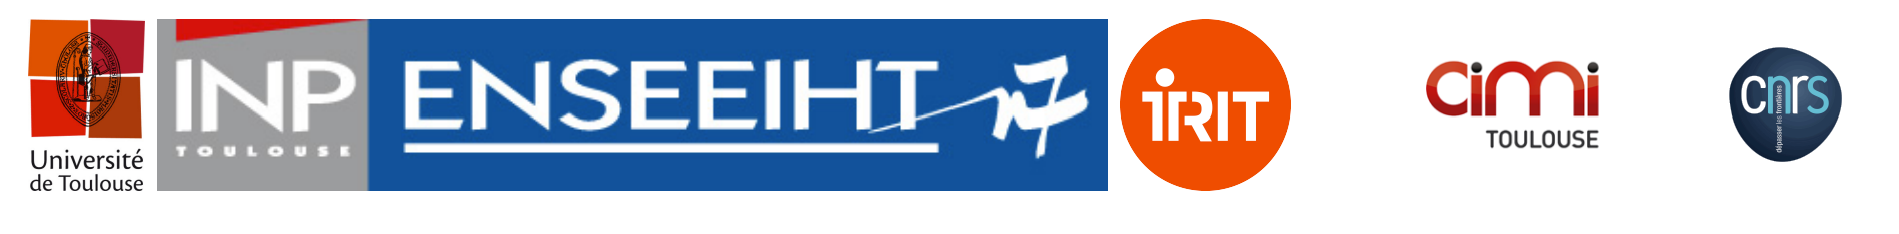

# Collocation method for the solution of singular perturbed problems


## Definition of the optimal control problem




$$
    \left\{
    \begin{array}{l}
        \min 0.5\int_{0}^{1}\left((y_1(t)-1)^2+(y_2(t)-1)^2+(u(t)-2)^2\right)t_f dt,\\
        \dot{y}(t) = t_f (y_2(t),1-y_1(t)+y_2^3(t)+u(t))\\
        y(0) = (1,1)\\
        y(1) = (3,0)
    \end{array}
    \right.
$$
with y = ($y_1$,$y_2$) 

The hamiltonien is given by the expression :
$$
\\
$$
$$
     H(y,p,p^0,u) = p^0(0.5 t_f ((y_1(t)-1)^2+(y_2(t)-1)^2+(u(t)-2)^2)) + p_1 t_f y_2(t) + p_2 t_f (1- y_1(t)+y_2^3(t)+u(t))\\
$$

The maximization conditions lead to : \
$$
          \dot{p}(t) = -\frac{\partial H}{\partial y} = -t_f(p^0 (y_1(t) -1) - p_2(t) , p^0 (y_2(t) - 1) + p_1(t) + 3 p_2(t) y_2^2(t))\\ 
               \dot{y}(t) = \frac{\partial H}{\partial p} = t_f(y_2(t) , 1-y_1(t)+y_2^3(t)+u(t))\\
     0 = \frac{\partial H}{\partial u} = p^0 t_f (u-2) + p_2 t_f\\
$$
     If $p^0$ = 0 then ($p^0$,p)=(0,(0,0)) impossible then $p^0$ = -1 
     and   \
     $$
     \
     $$
$$
     \dot{p}(t) = t_f(y_1(t) -1 + p_2(t) , y_2(t) - 1 - p_1(t) - 3 p_2(t) y_2^2(t))\\
     \dot{y}(t) = t_f(y_2(t) , 1-y_1(t)+y_2^3(t)+u(t))\\
     u(t) = 2 + p_2(t) \\
$$

## Associated boundary value problem 

$$
    \left\{
    \begin{array}{l}    
       \varepsilon \dot{y}(t) = (y_2(t),1-y_1(t)+y_2^3(t)+u(t))\\
       \varepsilon \dot{p}(t) = (y_1(t)+p_2(t)-1,y_2(t)-3y_2^2(t)p_2(t)-p_1(t)-1)\\
        y(0) = (1,1)\\
        y(1) = (3,0)
    \end{array}
    \right.
$$
With $\varepsilon = 1/t_f$ , y = ($y_1$,$y_2$) and p = ($p_1$,$p_2$)

As $\varepsilon$ becomes increasingly smaller for this problem, the solution generally becomes increasingly harder to approximate directly. The aim is to solve the problem using the collocation method.Then, we are looking for an approximate solution : $y_i$ = y($t_i$) and $p_i$ = p($t_i$) for i in [1:N+1] where N is the mesh size.

## Trapeze scheme


$$
y_{i+1} = y_i + (t_{i+1} - t_i) \frac{dy_{i+1} + dy_i}{2}\\
$$
then
$$
y_{i+1} = y_i + h_i \frac{dy_{i+1} + dy_i}{2}\\
$$
with  $h_i$ = $t_{i+1}$ - $t_i$

## Euler scheme
$$
y_{i+1} = y_i + (t_{i+1} - t_i) dy_i\\
$$
then
$$
y_{i+1} = y_i + h_i dy_i\\
$$
with  $h_i$ = $t_{i+1}$ - $t_i$




In most cases, the solution obtained by the two previous schemes is not the exact solution of the problem.
Discretization error is the principal source of error in methods of finite differences of computational physics. The aim is to minimize the discretization error taking into account the values of $\varepsilon$ and other parameters such as the mesh size and the initial guess of the solution.

In [1]:
using JuMP   # NLP modelling
using Ipopt  # NLP solver
using Plots
using DataFrames
using CSV


(process:5844): GLib-GIO-WARNING **: 14:07:21.905: Unexpectedly, UWP app `Microsoft.ZuneMusic_10.22031.10091.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ZuneMusic_8wekyb3d8bbwe!Microsoft.ZuneMusic') supports 20 extensions but has no verbs

(process:5844): GLib-GIO-WARNING **: 14:07:21.955: Unexpectedly, UWP app `Microsoft.ZuneVideo_10.22041.10091.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ZuneVideo_8wekyb3d8bbwe!Microsoft.ZuneVideo') supports 33 extensions but has no verbs

(process:5844): GLib-GIO-WARNING **: 14:07:22.069: Unexpectedly, UWP app `DellInc.DellSupportAssistforPCs_3.11.20.0_x64__htrsf667h5kn2' (AUMId `DellInc.DellSupportAssistforPCs_htrsf667h5kn2!App') supports 1 extensions but has no verbs


### Direct method with constant step

In [2]:
function plotsolution_U(t, x1, x2,c,u)
   p1 = plot(t,x1, label = "x1(t)" ,  lw = 0.5)
   p2 = plot(t,x2, label = "x2(t)",  lw = 0.5)
   p3 = plot(t,c, label = "c(t)",  lw = 0.5)
   p4 = plot(t,u, label = "u(t)",  lw = 0.5)
   plot(p1,p2,p3,p4,size=(800, 600))
end

plotsolution_U (generic function with 1 method)

In [3]:
function nlpsolve_U(t_f, N,condI)
            sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 1))
            set_optimizer_attribute(sys,"tol",1e-8)
            set_optimizer_attribute(sys,"constr_viol_tol",1e-6)

            # Parameters
                t0 = 0.
                tf = 1. 
                Δt = (tf-t0)/N

            @variables(sys, begin
                c[1:N+1]       
                x1[1:N+1]
                x2[1:N+1]
                u[1:N+1]
            end)

                for i in 1:N+1
                   set_start_value(x1[i],condI[1]);
                   set_start_value(x2[i],condI[2]); 
                   set_start_value(c[i],condI[3]);
                   set_start_value(u[i],condI[4]);
                end

            # Objective
            @objective(sys, Min, c[N+1])


            @constraints(sys, begin
                con_c0, c[1] - 0.  == 0
                con_x0_1, x1[1]   - 1. == 0   
                con_x0_2, x2[1]   - 1. == 0   
                con_xf_1, x1[N+1] - 3. == 0
                con_xf_2, x2[N+1] - 0. == 0   
            end)


            @NLexpressions(sys, begin
                dc[j = 1:N+1],  0.5*((x1[j]-1)^2 + (x2[j]-1)^2 + (u[j]-2)^2)
                dx1[j = 1:N+1],  t_f*x2[j]
                dx2[j = 1:N+1],  t_f*(1.0-x1[j]+x2[j]^3+u[j])    
            end)



            @NLconstraints(sys, begin    
                con_c[j = 1:N], c[j+1] == c[j] + 0.5 * Δt * (dc[j+1] + dc[j]) # Scheme 1
                con_x1[j = 1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j]) # Scheme 1
                con_x2[j = 1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j]) # Scheme 1

            end)
    
            status = optimize!(sys)
            if termination_status(sys) == MOI.OPTIMAL
                  conv ="yes"
                
            elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
                  conv ="yes"
                
            elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
                  conv ="yes"
               
            else
                  conv ="no"
                
            end

            obj = objective_value(sys)
            # Retrieves values 
            c  = value.(c)[:]
            x1  = value.(x1)[:]
            x2  = value.(x2)[:]
            u  = value.(u)[:]
            t = zeros((N+1))
            t[1] = t0 ;
            for i in 1:N
                t[i+1] = Δt + t[i]
            end
            return (t, x1, x2, c,u,conv,obj)
end;


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



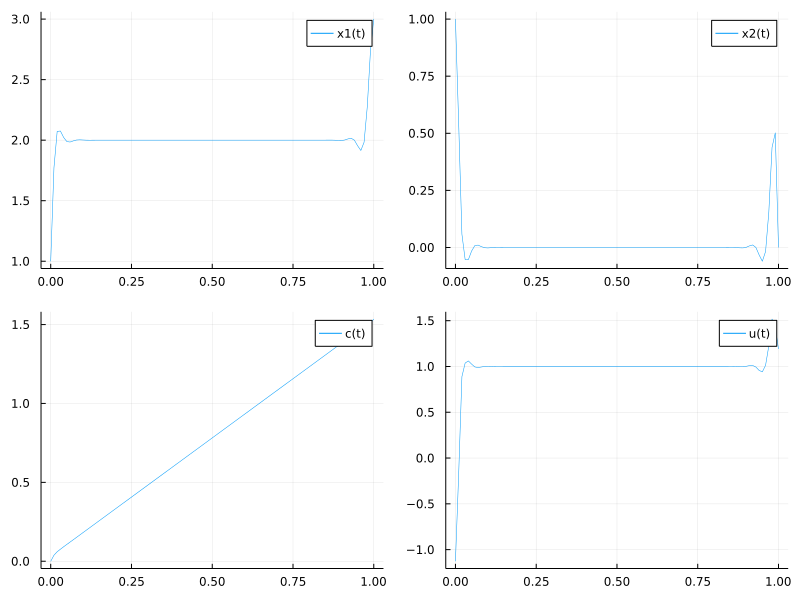

In [4]:
N=100
t_f = 100
t0 = 0.
tf = 1. 
Δt = (tf-t0)/N
t, x1, x2, c,u,conv,obj=nlpsolve_U(t_f, N,[2.,0.,1.5,1.]);
plotsolution_U(t, x1, x2,c,u)

### Direct method with variable step

In [5]:
function plotsolution_V(t, x1, x2,c,u, h,Δt,N)
   p1 = plot(t,x1, label = "x1(t)" ,  lw = 0.5)
   p2 = plot(t,x2, label = "x2(t)",  lw = 0.5)
   p3 = plot(t,c, label = "c(t)",  lw = 0.5)
   p4 = plot(t,u, label = "u(t)",  lw = 0.5)
   p5 = plot(scatter(t[1:N],[h,Δt*ones(N)], label = ["h(t)" "Δt"], lw = 0.5))
   p6 = plot(scatter(t[1:N],(h-Δt*ones(N)).^2, label = "(h-Δt).^2" , lw = 0.5))
   plot(p1,p2,p3,p4,p5,p6,size=(800, 600))
end


plotsolution_V (generic function with 1 method)

In [6]:
function nlpsolve_V(t_f, N,condI)
            sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 1))
            set_optimizer_attribute(sys,"tol",1e-8)
            set_optimizer_attribute(sys,"constr_viol_tol",1e-6)

            # Parameters
                t0 = 0.
                tf = 1. 
                Δt = (tf-t0)/N
                α = 1e-3

            @variables(sys, begin
                c[1:N+1]       
                x1[1:N+1]
                x2[1:N+1]
                u[1:N+1]
                0. ≤ h[1:N] ≤ tf-t0
            end)

                for i in 1:N
                    set_start_value(h[i],condI[1]);
                end

                for i in 1:N+1
                   set_start_value(x1[i],condI[2]);
                   set_start_value(x2[i],condI[3]); 
                   set_start_value(c[i],condI[4]);
                   set_start_value(u[i],condI[5]);
                end

            # Objective
            @objective(sys, Min, c[N+1]+α*sum((h-Δt*ones(N)).^2))


            @constraints(sys, begin
                con_c0, c[1] - 0.  == 0
                con_x0_1, x1[1]   - 1. == 0   
                con_x0_2, x2[1]   - 1. == 0   
                con_xf_1, x1[N+1] - 3. == 0
                con_xf_2, x2[N+1] - 0. == 0   
            end)

            @constraint(sys, con_h, sum(h) == tf - t0)

            @NLexpressions(sys, begin
                dc[j = 1:N+1],  0.5*((x1[j]-1)^2 + (x2[j]-1)^2 + (u[j]-2)^2)
                dx1[j = 1:N+1],  t_f*x2[j]
                dx2[j = 1:N+1],  t_f*(1.0-x1[j]+x2[j]^3+u[j])    
            end)



            @NLconstraints(sys, begin    
                con_c[j = 1:N], c[j+1] == c[j] + 0.5 * h[j] * (dc[j+1] + dc[j]) # Scheme 1
                con_x1[j = 1:N], x1[j+1] == x1[j] + 0.5 * h[j] * (dx1[j+1] + dx1[j]) # Scheme 1
                con_x2[j = 1:N], x2[j+1] == x2[j] + 0.5 * h[j] * (dx2[j+1] + dx2[j]) # Scheme 1

            end)

            status = optimize!(sys)

            if termination_status(sys) == MOI.OPTIMAL
                conv ="yes"
            elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
                conv = "yes"
            elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
                conv = "yes"
            else
                 conv = "no"
            end

            obj = objective_value(sys)
            # Retrieves values 
            c  = value.(c)[:]
            x1  = value.(x1)[:]
            x2  = value.(x2)[:]
            u  = value.(u)[:]
            h = value.(h)[:]
            t = zeros((N+1))
            t[1] = t0 ;
            for i in 1:N
                t[i+1] = h[i] + t[i]
            end
            return (t, x1, x2, c,h,u,conv,obj)
end;

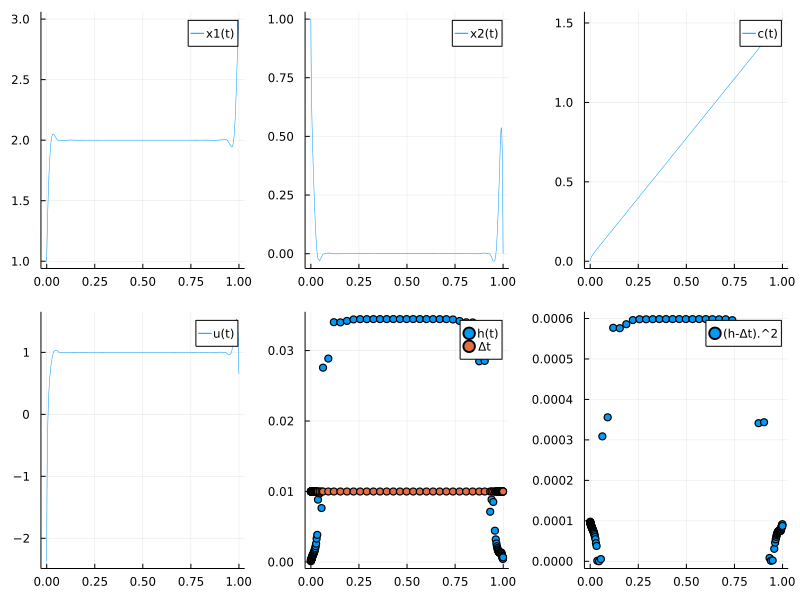

In [7]:
N=100
t_f = 100
t0 = 0.
tf = 1. 
Δt = (tf-t0)/N
t, x1, x2, c,h,u,conv,obj=nlpsolve_V(t_f, N,[Δt,2.,0.,1.5,1.]);
plotsolution_V(t, x1, x2,c,u, h,Δt,N)

### Collocation method

In [8]:
function plotsolution(t, x1, x2, x3, x4, y1, y2, y3, y4, h,Δt,N)
   p1 = plot(t,[x1,y1], label = ["x1(t)" "y1(t)"],  lw = 0.5)
   p2 = plot(t,[x2,y2], label = ["x2(t)" "y2(t)"],  lw = 0.5)
   p3 = plot(t,[x3,y3], label = ["x3(t)" "y3(t)"],  lw = 0.5)
   p4 = plot(t,[x4,y4], label = ["x4(t)" "y4(t)"], lw = 0.5)
   p5 = plot(t,[2.0.+x4,2.0.+y4], label = ["u1(t)" "u2(t)"],  lw = 0.5)
   p6 = plot(scatter(t[1:N],[h,Δt*ones(N)], label = ["h(t)" "Δt"], lw = 0.5))
   x=[x1,x2,x3,x4]
   y=[y1,y2,y3,y4]
   p7 = plot(t,x-y, label = ["x1-y1" "x2-y2" "x3-y3" "x4-y4"], lw = 0.5)
   p8 = plot(scatter(t[1:N],(h-Δt*ones(N)).^2, label = "(h-Δt).^2" , lw = 0.5))
   plot(p1,p2,p3,p4,p5,p6,p7,p8 ,size=(800, 600))
end

plotsolution (generic function with 1 method)

In [15]:
function affichage(t_init,t_end,N_p)
            t0 = 0.
            tf = 1.
            Δt = (tf-t0)/N_p


            liste1 = []
            liste2 = []

            for p in t_init:10:t_end
                   #the static solution as the primal start value
                   t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv1,obj1 = bvpsolve(p, N_p,[Δt,2,0,-1,-1])
                   #an arbitrary solution as the primal start value
                   t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv2,obj2 = bvpsolve(p, N_p,[0,8,6,-4,-7])
                    if ( conv1== "no")
                        t_end = p
                        append!(liste1,"X")
                        if ( conv2 == "no")
                           append!(liste2,"X")
                        else
                           append!(liste2,obj2)
                        end
                        break
                    else
                        append!(liste1,obj1)
                    end
                    if(conv2 == "no")
                         append!(liste2,"X")
                    else
                    append!(liste2,obj2)
                     end
            end

           d = DataFrame(tf=t_init:10:t_end, N=repeat(N_p:N_p, inner=size(t_init:10:t_end)), Objective_Value_SS =liste1,Objective_Value_AS =liste2)
end


affichage (generic function with 1 method)

In [16]:
function bvpsolve(t_f, N,condI)

    # Create JuMP model, using Ipopt as the solver
    bvp = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 1, "tol" => 1e-8, "constr_viol_tol" => 1e-6)) # or 5

    # Parameters
    α  = 1e-3 # L2-norm regularization factor
    n  = 4
    
    t0 = 0.
    tf = 1.
    t = zeros((N+1)) 
    Δt = (tf-t0)/N
    
    # State and control variables
    @variables(bvp, begin
        x[1:N+1, 1:n]
        y[1:N+1, 1:n]
        0. ≤ h[1:N] ≤ tf-t0
    end)
     
    #Static solution as the primal start value (2,0,-1,-1)  h=Δt  condI = (Δt,2,0,-1,-1)
    
    # An arbitrary solution as the primal start value(4,7,-3,4) h=0   condI = (0,4,7,-3,4)

    
    for i in 1:N
        set_start_value(h[i],condI[1]);
    end
       
    for i in 1:N+1
       set_start_value(x[i,1],condI[2]);
       set_start_value(x[i,2],condI[3]);
       set_start_value(x[i,3],condI[4]);
       set_start_value(x[i,4],condI[5]);
       set_start_value(y[i,1],condI[2]);
       set_start_value(y[i,2],condI[3]);
       set_start_value(y[i,3],condI[4]);
       set_start_value(y[i,4],condI[5]);     
    end
       

    # Objective
          
       @objective(bvp, Min, sum(sum((x-y).^2))/N + α*sum((h-Δt*ones(N)).^2))

    # Initial and final conditions
    @constraints(bvp, begin
        con_x0_1, x[1,1]   - 1. == 0   
        con_x0_2, x[1,2]   - 1. == 0   
        con_xf_1, x[N+1,1] - 3. == 0
        con_xf_2, x[N+1,2] - 0. == 0   
    end)
    
    @constraints(bvp, begin
        con_y0_1, y[1,1]   - 1. == 0
        con_y0_2, y[1,2]   - 1. == 0
        con_yf_1, y[N+1,1] - 3. == 0
        con_yf_2, y[N+1,2] - 0. == 0
    end)

    
    @constraint(bvp, con_h, sum(h) == tf - t0)
    
    # Dynamics
    @NLexpressions(bvp, begin
        ux[j = 1:N+1],   2.0+x[j,4]
        dx1[j = 1:N+1],  t_f*x[j,2]
        dx2[j = 1:N+1],  t_f*(1.0-x[j,1]+x[j,2]^3+ux[j])
        dx3[j = 1:N+1],  t_f*(x[j,1]+x[j,4]-1.0)
        dx4[j = 1:N+1],  t_f*(x[j,2]-3.0*x[j,2]^2*x[j,4]-x[j,3]-1.0)
    end)
  
    @NLexpressions(bvp, begin
        uy[j = 1:N+1],   2.0+y[j,4]
        dy1[j = 1:N+1],  t_f*y[j,2]
        dy2[j = 1:N+1],  t_f*(1.0-y[j,1]+y[j,2]^3+uy[j])
        dy3[j = 1:N+1],  t_f*(y[j,1]+y[j,4]-1.0)
        dy4[j = 1:N+1],  t_f*(y[j,2]-3.0*y[j,2]^2*y[j,4]-y[j,3]-1.0)
    end)
    
    # Discretization of the dynamics
    
    @NLconstraints(bvp, begin
            
        # Trapeze Scheme
        con_x1[j = 1:N], x[j+1,1] == x[j,1] + 0.5 * h[j] * (dx1[j+1] + dx1[j]) # Scheme 1
        con_x2[j = 1:N], x[j+1,2] == x[j,2] + 0.5 * h[j] * (dx2[j+1] + dx2[j]) # Scheme 1
        con_x3[j = 1:N], x[j+1,3] == x[j,3] + 0.5 * h[j] * (dx3[j+1] + dx3[j]) # Scheme 1
        con_x4[j = 1:N], x[j+1,4] == x[j,4] + 0.5 * h[j] * (dx4[j+1] + dx4[j]) # Scheme 1
            
        # Euler Scheme
        con_y1[j = 1:N], y[j+1,1] == y[j,1] + h[j] * dy1[j]                     # Scheme 2
        con_y2[j = 1:N], y[j+1,2] == y[j,2] + h[j] * dy2[j]                     # Scheme 2
        con_y3[j = 1:N], y[j+1,3] == y[j,3] + h[j] * dy3[j]                     # Scheme 2
        con_y4[j = 1:N], y[j+1,4] == y[j,4] + h[j] * dy4[j]                     # Scheme 2
            
    end)

    
    #
    status = optimize!(bvp)
    
    if termination_status(bvp) == MOI.OPTIMAL
        conv = "yes" 
    elseif  termination_status(bvp) == MOI.LOCALLY_SOLVED
        conv = "yes" 
    elseif termination_status(bvp) == MOI.TIME_LIMIT && has_values(bvp)
        conv = "yes"
    else
        conv = "no"
    end
    
    obj  = objective_value(bvp)
    
    # Outputs
    x1  = value.(x)[:,1]
    x2  = value.(x)[:,2]
    x3  = value.(x)[:,3]
    x4  = value.(x)[:,4]
    y1  = value.(y)[:,1]
    y2  = value.(y)[:,2]
    y3  = value.(y)[:,3]
    y4  = value.(y)[:,4]
    h  = value.(h)[:]
    t[1] = t0 ;
    for i in 1:N
        t[i+1] = h[i] + t[i]
    end
    
    return (t, x1, x2, x3, x4, y1, y2, y3, y4, h,conv,obj)
end;

In [17]:
t_init = 10 # valeur initiale du paramètre
t_end  = 110 # valeur finale du paramètre
N_p    = 120 # nombre de pas
affichage(t_init,t_end,N_p)

,tf,N,Objective_Value_SS,Objective_Value_AS
,Int64,Int64,Any,Any
1,10,120,0.000592421,0.000592421
2,20,120,0.000666687,0.000666687
3,30,120,0.000734199,0.000734199
4,40,120,0.000820513,0.117101
5,50,120,0.00083261,0.000881642
6,60,120,0.000996987,0.000996987
7,70,120,0.00129785,0.00129785
8,80,120,0.00162432,0.00171839
9,90,120,0.00218751,X


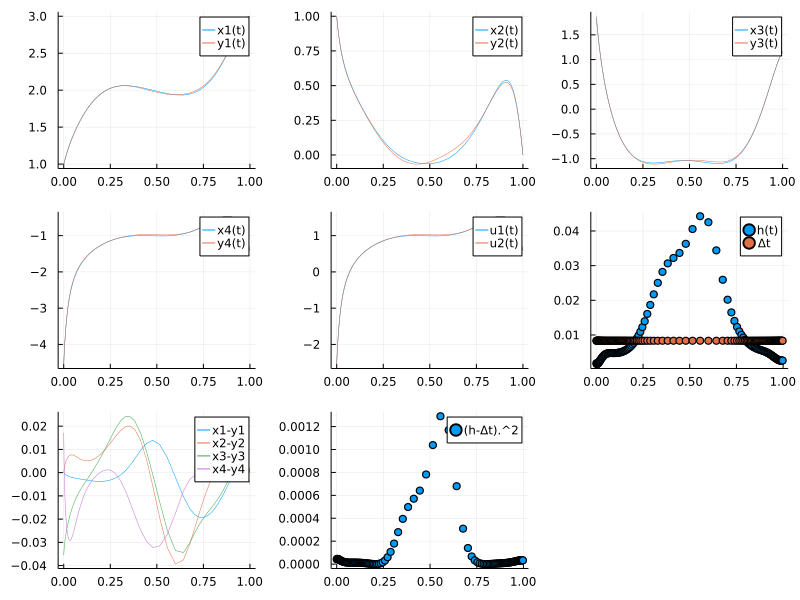

In [12]:
t_f  = 10.0 
N_p  = 120
t0 = 0.
tf = 1.
Δt = (tf-t0)/N_p
t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv,obj = bvpsolve(t_f, N_p,[Δt,2,0,-1,-1])

plotsolution(t, x1, x2, x3, x4, y1, y2, y3, y4, h,Δt,N_p)


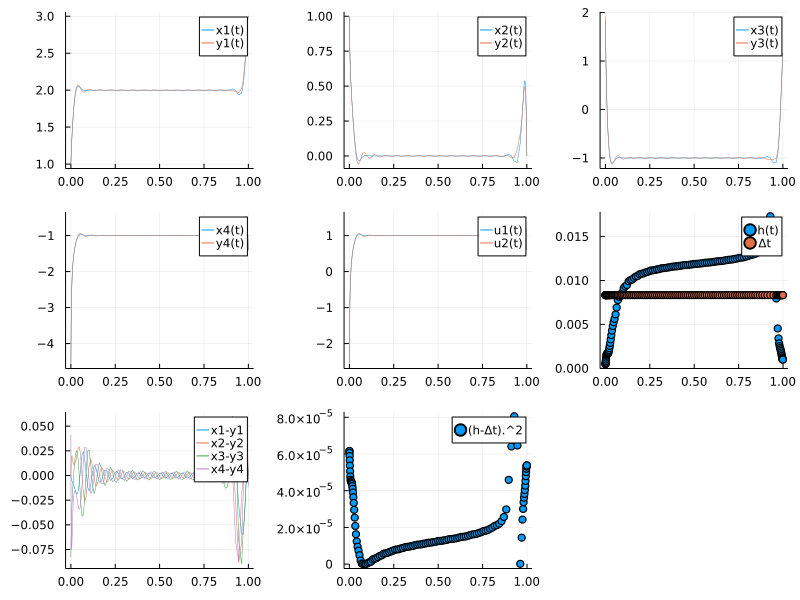

In [13]:
t_f  = 80.0 
N_p  = 120
t0 = 0.
tf = 1.
Δt = (tf-t0)/N_p
t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv,obj = bvpsolve(t_f, N_p,[Δt,2,0,-1,-1])

plotsolution(t, x1, x2, x3, x4, y1, y2, y3, y4, h,Δt,N_p)


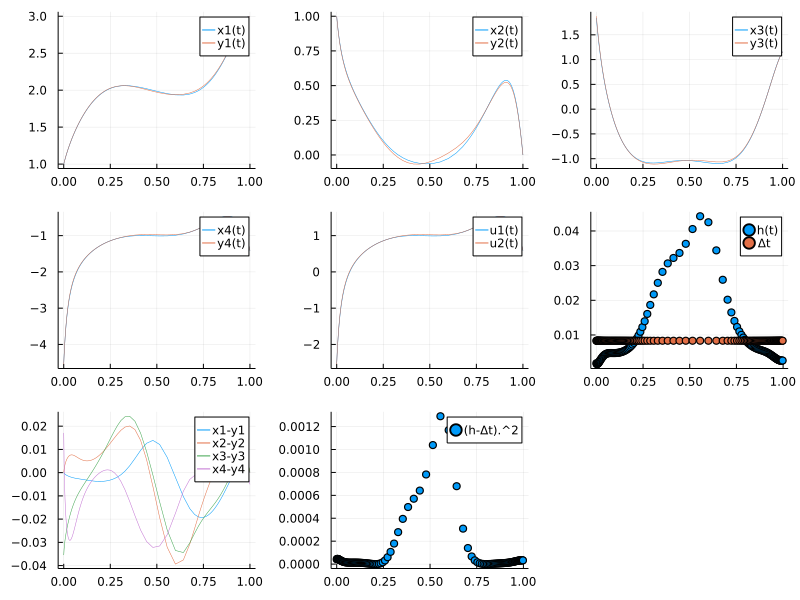

In [14]:
t_f  = 10.0 
N_p  = 120
t0 = 0.
tf = 1.
Δt = (tf-t0)/N_p
t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv,obj = bvpsolve(t_f, N_p,[0,8,6,-4,-7])

plotsolution(t, x1, x2, x3, x4, y1, y2, y3, y4, h,Δt,N_p)


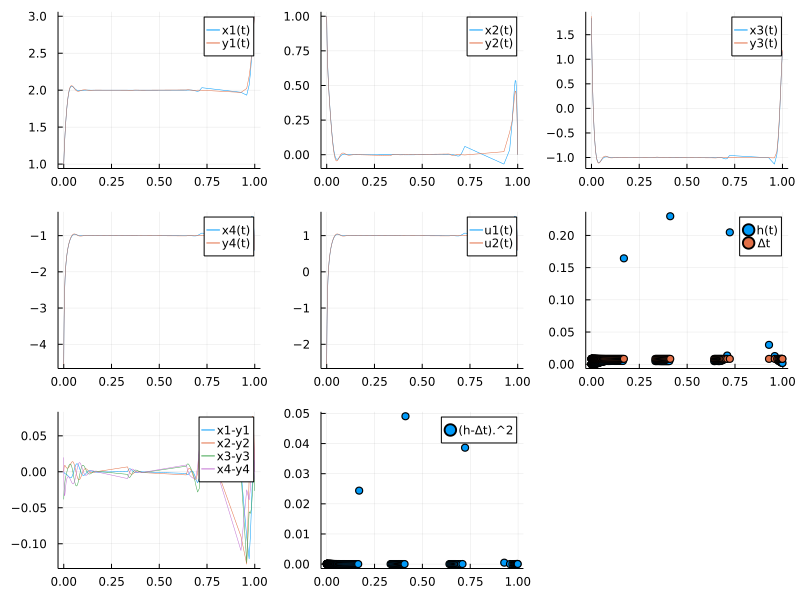

In [15]:
t_f  = 80.0 
N_p  = 120
t0 = 0.
tf = 1.
Δt = (tf-t0)/N_p
t,x1, x2, x3, x4, y1, y2, y3, y4, h,conv,obj = bvpsolve(t_f, N_p,[0,8,6,-4,-7])

plotsolution(t, x1, x2, x3, x4, y1, y2, y3, y4, h,Δt,N_p)


### Saving the solution in a CSV file

In order to have access to the solution at any time, we have decided to save it in a CSV file.

In [34]:
#Création d'une liste des expériences
XP = []
function listeXP(t_init,pas,t_end,algo,schema,condI,N)
   for t in t_init:pas:t_end
      append!(XP,[[algo,schema,condI,t,N]])
   end
   return XP
end

listeXP (generic function with 1 method)

In [35]:
#Exécuter une expérience
function execute(algo,t_f,N,condI)
   #n = length(algo(t_f,N,condI))
   #conv= algo(t_f,N,condI)[n-1]
   #obj= algo(t_f,N,condI)[n]
   #time = @elapsed algo(t_f,N,condI)
   time =@elapsed (a = algo(t_f,N,condI))
   n = length(a)
   conv = a[n-1]
   obj = a[n] 
   return conv,obj,time
end

#Vérifier si une XP est sauvegardée 
function save(file,algo,schema,condI,t_f,N)
    
       #Vérifier si le fichier existe ou pas
       if (isfile(file) && (length(readlines(file)) > 1))
           #Si le fichier existe on crée une dataFrame à partir de ce fichier
            #CSV to DataFrame
            df = DataFrame(CSV.File(file))   
       else
            #Création d'une DataFrame vide si le fichier n'existe pas
            df = DataFrame(Algorithm=Any[], Scheme=String[],Initialization=Any[] ,tf=Int[], N=Int[],Convergence = Any[], Objective_Value=Any[], Time_cpu=Any[])
            #DataFrame to CSV
            CSV.write(file,df)           
       end
        exp1 = [];
        #Extraction de trois colonnes du fichier csv et les enregistrer dans une liste
        e = CSV.File(file; select=(i, nm) -> i in ( 2, 4, 5,7))
            for i in 1:length(e)
            for j in 1:4
               append!(exp1,[e[i][j]])
            end
        end
    
        #Vérifier si une expérience est déjà sauvegardée ou pas
        conv,obj,time = execute(algo,t_f,N,condI)
        if (issubset([schema,t_f,N,obj], exp1)) == false
          #conv,obj,time = execute(algo,t_f,N,condI)
          push!(df,(String(string(algo)),schema,string(condI),t_f,N,String(string(conv)),obj,time))
          CSV.write(file,df)
        end
        return exp1
       
end

#Remplissage de la DataFrame et sauvegarde dans le fichier csv
function remp(file,liste)
    for k in 1:length(liste)
      ll = liste[k][:]
      exp1 = save(file,ll[1],ll[2],ll[3],ll[4],ll[5])
    end
    df = DataFrame(CSV.File(file))
    println(df)
    return df
end

remp (generic function with 1 method)

In [36]:
t0 = 0.
tf = 1.
N = 400
Δt = (tf-t0)/N
XP = listeXP(10,10,100,bvpsolve,"EulerTrapeze",[Δt,2,0,-1,-1],N);

In [37]:
N=400
t0 = 0.
tf = 1. 
Δt = (tf-t0)/N
XP = listeXP(10,10,100,nlpsolve_V,"Trapeze",[Δt,2.,0.,1.5,1.],N);

In [38]:
XP =  listeXP(10,10,100,nlpsolve_U,"Trapeze",[2.,0.,1.5,1.],N);


In [39]:
df =remp("turnpike.csv",XP);

30×8 DataFrame
 Row │ Algorithm   Scheme        Initialization                  tf     N      Convergence  Objective_Value  Time_cpu   
     │ String15    String15      String31                        Int64  Int64  String3      Float64          Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     10    400  yes               5.81597e-5    6.09093
   2 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     20    400  yes               6.31969e-5   42.1168
   3 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     30    400  yes               6.59519e-5   62.7025
   4 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     40    400  yes               6.76809e-5   55.8793
   5 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     50    400  yes               6.88693e-5   93.2476
   6 │ bvpsolve    EulerTrapeze

In [40]:
function supprimerXP(file,algo,t_f,N,condI,schema)
    lignes = readlines(file)
    conv,obj,time = execute(algo,t_f,N,condI)
    df = DataFrame(CSV.File(file))
    n = length(lignes)
    index = [k for k in 1:n-1]
    for i in 2:n
        taille = length(split(lignes[i],","))
        if (taille == 12)
        a,z,e,r,t,y,u,l,p,q,s,d=split(lignes[i],",")
        else
        a,z,r,t,y,u,l,p,q,s,d=split(lignes[i],",")
        end

        if ( a ==String(string(algo)) && z == schema  && parse(Int64,l) ==t_f && parse(Int64,p) ==N  && q ==String(string(conv)) && parse(Float64,s) ==obj)
            j = i-1
            liste = deleteat!(index, findall(x->x==j,index))
            df1 = df[liste,:]
            println(df1)
            CSV.write(file,df1)
        end
          
    end
    
end

supprimerXP (generic function with 1 method)

In [41]:
N=400
t_f = 30
t0 = 0.
tf = 1. 
Δt = (tf-t0)/N
supprimerXP("turnpike.csv",bvpsolve,t_f,N,[Δt,2,0,-1,-1],"EulerTrapeze")

29×8 DataFrame
 Row │ Algorithm   Scheme        Initialization                  tf     N      Convergence  Objective_Value  Time_cpu   
     │ String15    String15      String31                        Int64  Int64  String3      Float64          Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     10    400  yes               5.81597e-5    6.09093
   2 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     20    400  yes               6.31969e-5   42.1168
   3 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     40    400  yes               6.76809e-5   55.8793
   4 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     50    400  yes               6.88693e-5   93.2476
   5 │ bvpsolve    EulerTrapeze  [0.0025, 2.0, 0.0, -1.0, -1.0]     60    400  yes               6.97974e-5  120.74
   6 │ bvpsolve    EulerTrapeze  